# 1.31e: Bulk Flow Correlation

**Question:** How strongly correlated is each token's displacement with the centroid displacement at each timestep?

Are all tokens moving in the same direction (coordinated stampede), or are they moving independently with the centroid barely budging (thermal noise)?

## Method

For each timestep t:

1. Compute each token's displacement: ΔW_i(t) = W_i(t+1) - W_i(t)
2. Compute centroid displacement: ΔC(t) = mean(ΔW_i(t)) over all dead tokens
3. For each token, compute correlation with bulk:

$$\rho_{\text{bulk},i}(t) = \frac{\Delta W_i(t) \cdot \Delta C(t)}{|\Delta W_i(t)| \cdot |\Delta C(t)|}$$

4. Plot: median ρ_bulk(t) over all tokens at each timestep

**Interpretation:**
- ρ_bulk ≈ 1: All tokens moving together (coordinated)
- ρ_bulk ≈ 0: Tokens moving independently (uncorrelated)

## Parameters

In [18]:
THIMBLE_PATH = "../tensors/Thimble/thimble_7.h5"
DPI = 200

## Imports

In [19]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [20]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [21]:
print(f"Loading data from {THIMBLE_PATH}...\n")

with h5py.File(THIMBLE_PATH, 'r') as f:
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    W_all = torch.from_numpy(f['W'][:]).view(torch.bfloat16)
    W_dead = W_all[:, dead_mask, :].to(torch.float32).to(device)
    
print(f"✓ Loaded W: {W_dead.shape}")
print(f"  Memory: {W_dead.element_size() * W_dead.nelement() / 1e9:.2f} GB")

Loading data from ../tensors/Thimble/thimble_7.h5...

✓ Loaded W: torch.Size([6001, 3699, 64])
  Memory: 5.68 GB


## Compute Displacements and Centroid

In [22]:
# Token displacements: ΔW(t) = W(t+1) - W(t)
delta_W = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)

# Centroid displacement: ΔC(t) = mean(ΔW(t))
delta_C = delta_W.mean(dim=1)  # (6000, 64)

print(f"ΔW shape: {delta_W.shape}")
print(f"ΔC shape: {delta_C.shape}")

ΔW shape: torch.Size([6000, 3699, 64])
ΔC shape: torch.Size([6000, 64])


## Compute Bulk Flow Correlation

In [23]:
# Dot product: ΔW · ΔC
dot_product = (delta_W * delta_C.unsqueeze(1)).sum(dim=2)  # (6000, 3699)

# Magnitudes
mag_W = torch.norm(delta_W, dim=2)  # (6000, 3699)
mag_C = torch.norm(delta_C, dim=1).unsqueeze(1)  # (6000, 1)

# Correlation
rho_bulk = dot_product / (mag_W * mag_C + 1e-30)  # (6000, 3699)

print(f"ρ_bulk computed: {rho_bulk.shape}")

ρ_bulk computed: torch.Size([6000, 3699])


## Compute Median Over Tokens

In [24]:
# Median correlation at each timestep
median_rho = torch.median(rho_bulk, dim=1).values.cpu().numpy()  # (6000,)

timesteps = np.arange(1, 6001)

print(f"Median ρ_bulk computed over {len(timesteps)} timesteps")

Median ρ_bulk computed over 6000 timesteps


## Plot: Median Bulk Flow Correlation

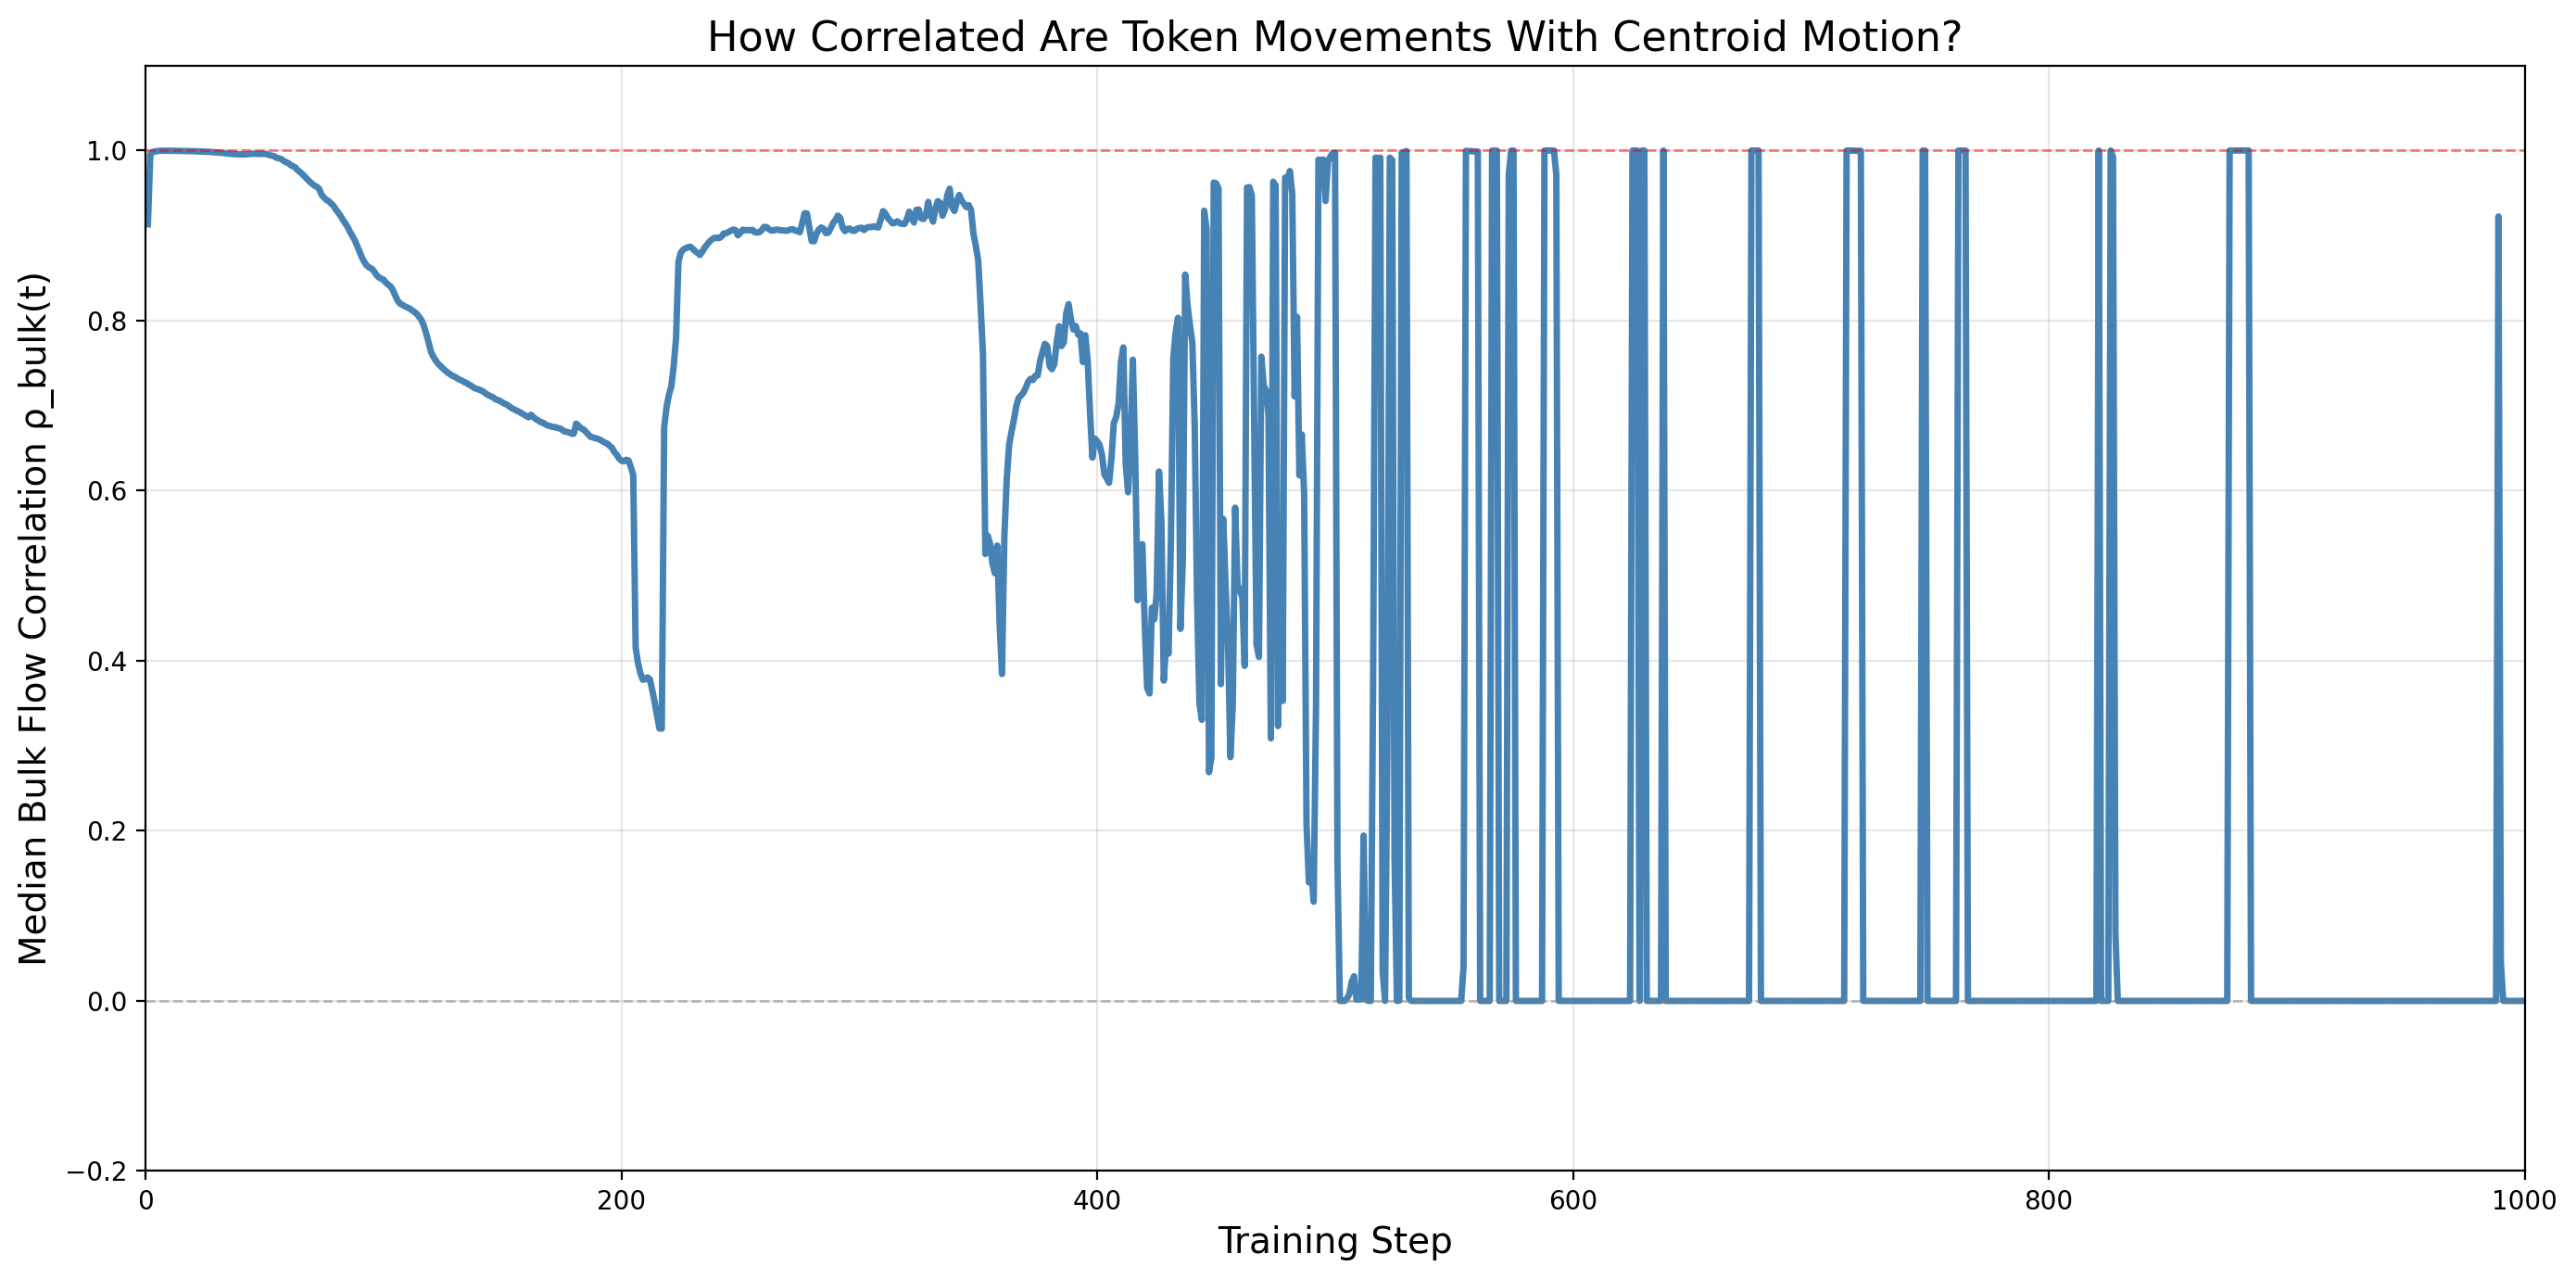

In [31]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=DPI)

ax.plot(timesteps, median_rho, color='steelblue', linewidth=2.5)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Median Bulk Flow Correlation ρ_bulk(t)', fontsize=14)
ax.set_title('How Correlated Are Token Movements With Centroid Motion?', fontsize=16)
ax.set_ylim(-0.2, 1.1)
ax.grid(True, alpha=0.3)

ax.set_xbound(0, 1000)

plt.tight_layout()
plt.show()

## Summary

In [32]:
early = np.median(median_rho[:100])
middle = np.median(median_rho[2500:2600])
late = np.median(median_rho[-100:])

print("=" * 80)
print("BULK FLOW CORRELATION")
print("=" * 80)
print()
print(f"Median ρ_bulk:")
print(f"  Early (t=1-100):      {early:.4f}")
print(f"  Middle (t=2500-2600): {middle:.4f}")
print(f"  Late (t=5900-6000):   {late:.4f}")
print()

if early > 0.8:
    print("→ Strong coherent bulk flow: tokens moving together")
elif early < 0.2:
    print("→ Independent motion: centroid barely moves")
else:
    print(f"→ Mixed: ρ ≈ {early:.2f}")

print()
print("=" * 80)

BULK FLOW CORRELATION

Median ρ_bulk:
  Early (t=1-100):      0.9950
  Middle (t=2500-2600): 0.0000
  Late (t=5900-6000):   0.0000

→ Strong coherent bulk flow: tokens moving together

